# 47.7. Project. Анализ посещений сайта роботами.
## Постановка задачи:  
Для определенного сайта с установленным счетчиком Яндекс-метрики требуется:
- Оценить количество ботов, которые заходят на сайт, и их долю от всего трафика.
- Определить, из каких источников и в какое время суток чаще всего заходят роботы.     
- Период для анализа - за сентябрь 2020.
- Модель аттрибуции - lastSign (последний значимый переход).

## 1. Импортируем необходимые библиотеки, создадим объекты для последующей авторизации в Яндекс-метрике.

In [1]:
import json 
import requests
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_rows', 4) 

token = '...hidden...' # авторизационный токен
headers = {'Authorization': 'OAuth ' + token}

## 2. Перечень метрик и группировок, используемых при анализе.

**Метрики**: 
- ym:s:visits 					— Визиты - Суммарное количество визитов.
- ym:s:pageviews 				— Просмотры - Число просмотров страниц на сайте за отчетный период.
- ym:s:users 					— Посетители - Количество уникальных посетителей.
- ym:s:pageDepth 				— Глубина просмотра - Количество страниц, просмотренных посетителем во время визита.
- ym:s:avgVisitDurationSeconds	— Время на сайте - Средняя продолжительность визита в секундах.
- ym:s:robotPercentage			- Роботность - Доля посетителей, предположительно являющихся роботами.

**Группировки**:
- ym:s:<attribution>TrafficSource	- Источник трафика
- ym:s:<attribution>SourceEngine 	- Источник трафика (детально) - Второй уровень источников трафика
- ym:s:date 						- Дата визита - Дата визита в формате YYYY-MM-DD.
- ym:s:hour 						- Час визита - Время начала часового периода в формате HH:MM
- ym:s:dayOfWeekName				- День недели визита 
- ym:s:isRobotName 					- Роботность - Посетитель предположительно является роботом

## 3. Оценка количества ботов, заходящих на сайт, и их долю от всего трафика.
### 3.1. Получение и обработка данных со счетчика Яндекс Метрики на сайте
Сделаем два запроса:
1. Запрос данных по визитам без группировки, но с метрикой процента роботов.
2. Запрос данных по визитам с группировкой по признаку "человек/робот"
#### 3.1.1. Запрос и обработка данных по визитам без группировки, но с метрикой процента роботов.
Сделаем запрос к счетчику и посмотрим на его ответ в "сыром" виде:

In [2]:
params_visit_total = {  'metrics':  'ym:s:visits,ym:s:users,ym:s:robotPercentage,\
                         ym:s:avgVisitDurationSeconds,ym:s:pageviews,ym:s:pageDepth', #ym:s:isRobot,
            'date1': '2020-09-01',  
            'date2': '2020-09-30',     
            'ids': 30177909,
            'accuracy':'full'}

response_visit_total = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params_visit_total, headers=headers)
print('\nResponse status code       :  ', response_visit_total.status_code)

response_visit_total_data = response_visit_total.json()
print('Number of rows in response :  ', response_visit_total_data['total_rows'])
print('\nResponse keys :\n', response_visit_total_data.keys())
print('\nResponce data value :')
pprint(response_visit_total_data['data'])


Response status code       :   200
Number of rows in response :   1

Response keys :
 dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])

Responce data value :
[{'dimensions': [],
  'metrics': [4315.0, 3166.0, 22.29432213, 90.0363847, 5226.0, 1.21112399]}]


 Переобразуем "сырой" ответ в таблицу-DataFrame:

In [3]:
data_visit_total_df=pd.DataFrame(data = response_visit_total_data['data']) 
display(data_visit_total_df)

,dimensions,metrics
0,[],"[4315.0, 3166.0, 22.29432213, 90.0363847, 5226..."


Уберем из таблицы пустой столбец dimensions; расставим метрики по отдельным столбцам
(при этом метрики по сути с целочисленными значениями преобразуем в целые числа, а метрики с по сути дробными значениями округлим до сотых или тысячных):

In [4]:
data_visit_total_df['visits']=data_visit_total_df['metrics'].apply(lambda x: x[0]).astype('int')
data_visit_total_df['users']=data_visit_total_df['metrics'].apply(lambda x: x[1]).astype('int')
data_visit_total_df['robot%']=data_visit_total_df['metrics'].apply(lambda x: round(x[2],2))
data_visit_total_df['avgVisitDurationSec']=data_visit_total_df['metrics'].apply(lambda x: round(x[3],2))
data_visit_total_df['pageviews']=data_visit_total_df['metrics'].apply(lambda x: x[4]).astype('int')
data_visit_total_df['pageDepth']=data_visit_total_df['metrics'].apply(lambda x: round(x[5],3))
data_visit_total_df.drop(['dimensions','metrics'],axis=1,inplace=True)
display(data_visit_total_df)

,visits,users,robot%,avgVisitDurationSec,pageviews,pageDepth
0,4315,3166,22.29,90.04,5226,1.211


#### 3.1.2. Запрос и обработка данных по визитам с группировкой по признаку "человек/робот.
Сделаем запрос к счетчику и посмотрим на его ответ в "сыром" виде:

In [5]:
params_visit_detailed = {  'metrics':  'ym:s:visits,ym:s:users,\
                         ym:s:avgVisitDurationSeconds,ym:s:pageviews,ym:s:pageDepth', 
            'dimensions':   'ym:s:isRobotName', 
            'date1': '2020-09-01',  
            'date2': '2020-09-30',     
            'ids': 30177909,
            'accuracy':'full'}

response_visit_detailed = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params_visit_detailed, headers=headers)
print('\nResponse status code       :  ', response_visit_detailed.status_code)

response_visit_detailed_data = response_visit_detailed.json()
print('Number of rows in response :  ', response_visit_detailed_data['total_rows'])
print('\nResponse keys :\n', response_visit_detailed_data.keys())
print('\nResponce data value :')
pprint(response_visit_detailed_data['data'])


Response status code       :   200
Number of rows in response :   2

Response keys :
 dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])

Responce data value :
[{'dimensions': [{'name': 'People'}],
  'metrics': [3353.0, 2515.0, 91.341187, 4058.0, 1.21025947]},
 {'dimensions': [{'name': 'Robots'}],
  'metrics': [962.0, 794.0, 85.48856549, 1168.0, 1.21413721]}]


 Переобразуем "сырой" ответ в таблицу-DataFrame:

In [6]:
data_visit_detailed_df=pd.DataFrame(data = response_visit_detailed_data['data']) 
display(data_visit_detailed_df)

,dimensions,metrics
0,[{'name': 'People'}],"[3353.0, 2515.0, 91.341187, 4058.0, 1.21025947]"
1,[{'name': 'Robots'}],"[962.0, 794.0, 85.48856549, 1168.0, 1.21413721]"


Расставим метрики по отдельным столбцам
(при этом метрики по сути с целочисленными значениями преобразуем в целые числа, а метрики с по сути дробными значениями округлим до сотых или тысячных):

In [7]:
data_visit_detailed_df['robot?']=data_visit_detailed_df['dimensions'].apply(lambda x: x[0]['name'])
data_visit_detailed_df['visits']=data_visit_detailed_df['metrics'].apply(lambda x: x[0]).astype('int')
data_visit_detailed_df['users']=data_visit_detailed_df['metrics'].apply(lambda x: x[1]).astype('int')
data_visit_detailed_df['avgVisitDurationSec']=data_visit_detailed_df['metrics'].apply(lambda x: round(x[2],2))
data_visit_detailed_df['pageviews']=data_visit_detailed_df['metrics'].apply(lambda x: x[3]).astype('int')
data_visit_detailed_df['pageDepth']=data_visit_detailed_df['metrics'].apply(lambda x: round(x[4],3))
data_visit_detailed_df.drop(['dimensions','metrics'],axis=1,inplace=True)
display(data_visit_detailed_df)

,robot?,visits,users,avgVisitDurationSec,pageviews,pageDepth
0,People,3353,2515,91.34,4058,1.210
1,Robots,962,794,85.49,1168,1.214


#### 3.1.3. Посмотрим на результаты двух обработанных запросов:

In [8]:
# в теблице data_total_df переместим столбец robot% в начало таблицы \
    # (цель - добиться однотипности колонок в таблицах data_total_df и data_people_vs_robots_df)
robot_percent=data_visit_total_df.pop('robot%')
data_visit_total_df.insert(0,'robot%',robot_percent)
display(data_visit_total_df)
display(data_visit_detailed_df)

,robot%,visits,users,avgVisitDurationSec,pageviews,pageDepth
0,22.29,4315,3166,90.04,5226,1.211


,robot?,visits,users,avgVisitDurationSec,pageviews,pageDepth
0,People,3353,2515,91.34,4058,1.210
1,Robots,962,794,85.49,1168,1.214


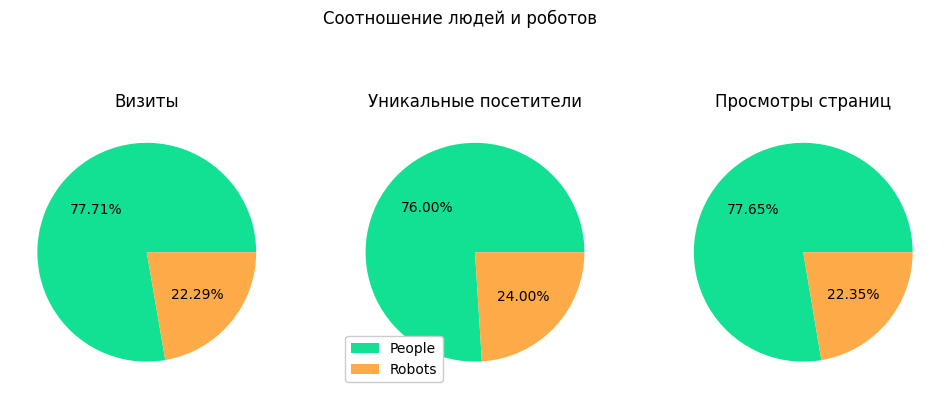

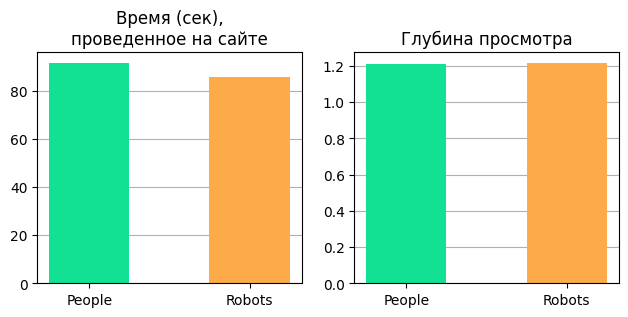

In [9]:
people_vs_robots_main, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
people_vs_robots_main.suptitle('Соотношение людей и роботов')

axes[0].pie(
    data_visit_detailed_df['visits'],
    autopct='%.2f%%',
    colors=['xkcd:aqua green','xkcd:light orange']);
axes[0].set_title('Визиты');

axes[1].pie(
    data_visit_detailed_df['users'],
    autopct='%.2f%%',
    colors=['xkcd:aqua green','xkcd:light orange']);
axes[1].set_title('Уникальные посетители');
axes[1].legend(data_visit_detailed_df['robot?'], loc='lower left', framealpha=1);

axes[2].pie(
    data_visit_detailed_df['pageviews'],
    autopct='%.2f%%',
    colors=['xkcd:aqua green','xkcd:light orange']);
axes[2].set_title('Просмотры страниц');


people_vs_robots_add, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 3))

axes[0].bar(
    x=data_visit_detailed_df['robot?'],
    height=data_visit_detailed_df['avgVisitDurationSec'],
    width=0.5, 
    color=['xkcd:aqua green','xkcd:light orange']);
axes[0].set_title('Время (сек),\nпроведенное на сайте');
axes[0].grid(axis='y');
axes[0].set_axisbelow(True);

axes[1].bar(
    x=data_visit_detailed_df['robot?'],
    height=data_visit_detailed_df['pageDepth'],
    width=0.5,
    color=['xkcd:aqua green','xkcd:light orange']);
axes[1].set_title('Глубина просмотра');
axes[1].grid(axis='y');
axes[1].set_axisbelow(True);

### ВЫВОДЫ:
1. Всего за сентябрь было зафиксировано 4315 визитов, сделанных 3166 уникальными посетителями;
   - из этих 4315 визитов 22% предположительно сделаны роботами;
   - из этих 3166 уникальных посетителей 24% предположительно являются роботами.
2. Дополнительные выводы:
   - посетитель-робот в среднем совершает чуть меньше визитов чем посетитель-человек;
   - продолжительность визита у робота в среднем немного меньше чем у чедовека;
   - в среднем количество просмотров страниц у людей и роботов практически одинаковое;
   - в среднем глубина просмотра страниц у людей и роботов практически одинаковая.

## 4. Определим, из каких источников и в какое время суток чаще всего заходят роботы. 
1. Определим, из каких источников чаще всего заходят роботы. 
2. Определим, в какое время суток чаще всего заходят роботы. 
3. Определим есть ли связь между типом источника и активностью роботов.
### 4.1. Определим, из каких источников чаще всего заходят роботы. 
1. Определим, из каких типов источников чаще всего заходят роботы. 
2. Определим, из каких конкретных источников-фавиконов чаще всего заходят роботы. 
#### 4.1.1. Определим, из каких типов источников чаще всего заходят роботы. 
Сделаем запрос данных по визитам с группировкой по типам источников:

In [10]:
params_source = {  'metrics':  'ym:s:visits,ym:s:robotPercentage', 
            'dimensions':   'ym:s:lastSignTrafficSource',  
            'date1': '2020-09-01',  
            'date2': '2020-09-30',     
            'ids': 30177909,
            'accuracy':'full'}

response_source = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params_source, headers=headers)
print('\nResponse status code       :  ', response_source.status_code)

response_source_data = response_source.json()
print('Number of rows in response :  ', response_source_data['total_rows'])
print('\nResponse keys :\n', response_source_data.keys())
print('\nResponce data value :')
pprint(response_source_data['data'])


Response status code       :   200
Number of rows in response :   7

Response keys :
 dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])

Responce data value :
[{'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'}],
  'metrics': [3334.0, 22.16556689]},
 {'dimensions': [{'icon_id': '0',
                  'icon_type': 'traffic-source',
                  'id': 'direct',
                  'name': 'Direct traffic'}],
  'metrics': [757.0, 23.38177015]},
 {'dimensions': [{'icon_id': '1',
                  'icon_type': 'traffic-source',
                  'id': 'referral',
                  'name': 'Link traffic'}],
  'metrics': [126.0, 24.6031746]},
 {'dimensions': [{'icon_id': '8',
                  'icon_type': 'traffic-source',
                

In [11]:
data_source_df=pd.DataFrame(data = response_source_data['data']) 
display(data_source_df)

,dimensions,metrics
0,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[3334.0, 22.16556689]"
1,"[{'icon_id': '0', 'icon_type': 'traffic-source...","[757.0, 23.38177015]"
...,...,...
5,"[{'icon_id': '4', 'icon_type': 'traffic-source...","[6.0, 16.66666667]"
6,"[{'icon_id': '9', 'icon_type': 'traffic-source...","[2.0, 0.0]"


In [12]:
#data_source_df['traffic-source-short']=data_source_df['dimensions'].apply(lambda x: x[0]['id'])
data_source_df['traffic-source']=data_source_df['dimensions'].apply(lambda x: x[0]['name'])
data_source_df['visits']=data_source_df['metrics'].apply(lambda x: x[0]).astype('int')
data_source_df['robot%']=data_source_df['metrics'].apply(lambda x: round(x[1],2))
data_source_df.drop(['dimensions','metrics'],axis=1,inplace=True)
data_source_df['visits_of_robots']=round(data_source_df['visits'] / 100 * data_source_df['robot%']).astype('int')
    # добавим столбец с количеством роботов на тип источника
data_source_df['visits_of_people']=data_source_df['visits'] - data_source_df['visits_of_robots']
    # добавим столбец с количеством людей на тип источника
pd.set_option('display.max_rows', 30) 
display(data_source_df.sort_values(['robot%'],ascending=False))

,traffic-source,visits,robot%,visits_of_robots,visits_of_people
4,Internal traffic,10,30.00,3,7
2,Link traffic,126,24.60,31,95
1,Direct traffic,757,23.38,177,580
0,Search engine traffic,3334,22.17,739,2595
5,Cached page traffic,6,16.67,1,5
3,Social network traffic,80,13.75,11,69
6,Recommendation system traffic,2,0.00,0,2


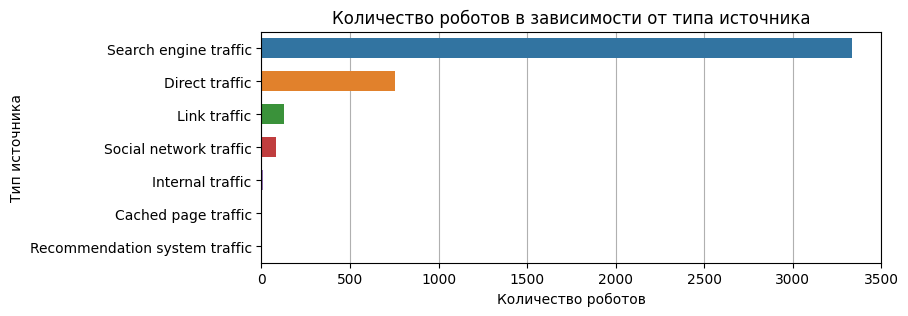

In [13]:
fig_source = plt.figure(figsize=(8, 3))
barplot = sns.barplot(
    data=data_source_df,
    y='traffic-source',
    x='visits',
    orient='h',
    width=0.6
)
barplot.set_title('Количество роботов в зависимости от типа источника');
barplot.set_xlabel('Количество роботов');
barplot.set_ylabel('Тип источника');
barplot.grid(axis='x');
barplot.set_axisbelow(True);

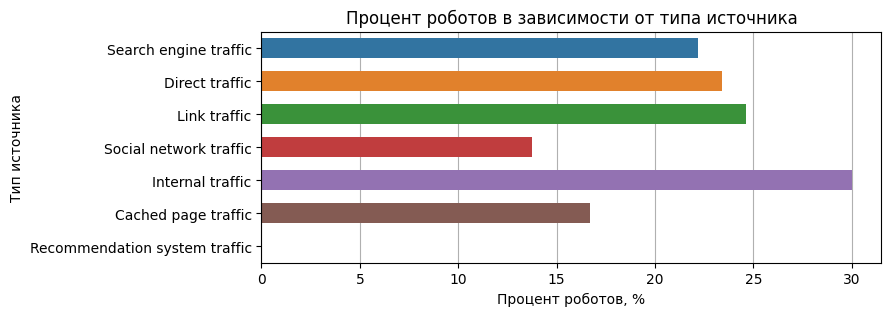

In [14]:
fig_sourcep = plt.figure(figsize=(8, 3))
barplot = sns.barplot(
    data=data_source_df,
    y='traffic-source',
    x='robot%',
    orient='h',
    width=0.6
)
barplot.set_title('Процент роботов в зависимости от типа источника');
barplot.set_xlabel('Процент роботов, %');
barplot.set_ylabel('Тип источника');
barplot.grid(axis='x');
barplot.set_axisbelow(True);

**Промежуточные ВЫВОДЫ**:
1. В абсолютном значении больше всего роботов приходило из следующих типов источника (в порядке убывания количества роботов):
   - Search engine traffic (739 визита роботов);
   - Direct traffic (177 визита роботов). 

   Эти типы источников занимают такие же места и по общему количеству визитов и по количеству визитов людей.
2. В процентах от количества визитов по типау источника наибольшая доля роботов наблюдается для следующих типов источника:
   - Internal traffic (30%);
   - Link traffic	(25%);
   - Direct traffic	(23%);
   - Search engine traffic	(22%).

#### 4.1.2. Определим, из каких конкретных источников чаще всего заходят роботы. 
Сделаем запрос данных по визитам с группировкой не только по типам источников, но и по конкретным источникам:

In [15]:
params_source_engine = {  'metrics':  'ym:s:visits,ym:s:robotPercentage', 
            'dimensions':   'ym:s:lastSignTrafficSource,ym:s:lastSignSourceEngine',  
            'date1': '2020-09-01',  
            'date2': '2020-09-30',     
            'ids': 30177909,
            'accuracy':'full'}

response_source_engine = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params_source_engine, headers=headers)
print('\nResponse status code       :  ', response_source_engine.status_code)

response_source_engine_data = response_source_engine.json()
print('Number of rows in response :  ', response_source_engine_data['total_rows'])
print('\nResponse keys :\n', response_source_engine_data.keys())
print('\nResponce data value :')
pprint(response_source_engine_data['data'])


Response status code       :   200
Number of rows in response :   24

Response keys :
 dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])

Responce data value :
[{'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'favicon': 'google.com',
                  'id': 'organic.google',
                  'name': 'Google',
                  'url': None}],
  'metrics': [2474.0, 25.70735651]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'favicon': 'www.yandex.ru',
                  'id': 'organic.yandex',
                  'name': 'Yandex',
                  'url': None}],
  'metrics': [8

In [16]:
data_source_engine_df=pd.DataFrame(data = response_source_engine_data['data']) 
display(data_source_engine_df)

,dimensions,metrics
0,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[2474.0, 25.70735651]"
1,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[856.0, 11.68224299]"
2,"[{'icon_id': '0', 'icon_type': 'traffic-source...","[757.0, 23.38177015]"
3,"[{'icon_id': '1', 'icon_type': 'traffic-source...","[88.0, 26.13636364]"
4,"[{'icon_id': '8', 'icon_type': 'traffic-source...","[48.0, 16.66666667]"
5,"[{'icon_id': '8', 'icon_type': 'traffic-source...","[25.0, 8.0]"
6,"[{'icon_id': '1', 'icon_type': 'traffic-source...","[23.0, 0.0]"
7,"[{'icon_id': '-1', 'icon_type': 'traffic-sourc...","[10.0, 30.0]"
8,"[{'icon_id': '4', 'icon_type': 'traffic-source...","[6.0, 16.66666667]"
9,"[{'icon_id': '1', 'icon_type': 'traffic-source...","[4.0, 75.0]"


In [17]:
#data_source_engine_df['traffic-source']=data_source_engine_df['dimensions'].apply(lambda x: x[0]['id'])
data_source_engine_df['traffic-source']=data_source_engine_df['dimensions'].apply(lambda x: x[0]['name'])
data_source_engine_df['favicon']=data_source_engine_df['dimensions'].apply(lambda x: x[1]['name'])
data_source_engine_df['visits']=data_source_engine_df['metrics'].apply(lambda x: round(x[0]))
data_source_engine_df['robot%']=data_source_engine_df['metrics'].apply(lambda x: round(x[1],2))
data_source_engine_df.drop(['dimensions','metrics'],axis=1,inplace=True)
data_source_engine_df['favicon']=data_source_engine_df['favicon'].apply(lambda x: 'not specified' if not x else x)
    # замена None на строку 'not specified' для последующего построения диаграмм при отсутсвующем фавиконе
data_source_engine_df['visits_of_robots'] \
    =round(data_source_engine_df['visits'] / 100 * data_source_engine_df['robot%']).astype('int')
    # добавим столбец с количеством роботов на тип источника
data_source_engine_df['visits_of_people'] \
    =data_source_engine_df['visits'] - data_source_engine_df['visits_of_robots']
    # добавим столбец с количеством людей на тип источника
pd.set_option('display.max_rows', 30) 
print('Визиты роботов (сортировка по типу источника, потом - по проценту роботов):')
display(data_source_engine_df.sort_values(['traffic-source','robot%'],ascending=[True,False]))

Визиты роботов (сортировка по типу источника, потом - по проценту роботов):


,traffic-source,favicon,visits,robot%,visits_of_robots,visits_of_people
8,Cached page traffic,not specified,6,16.67,1,5
2,Direct traffic,not specified,757,23.38,177,580
7,Internal traffic,not specified,10,30.00,3,7
16,Link traffic,getpocket.com,1,100.00,1,0
17,Link traffic,medium.com,1,100.00,1,0
19,Link traffic,tristablog.online,1,100.00,1,0
9,Link traffic,toolmark.ru,4,75.00,3,1
11,Link traffic,basecamp.com,3,66.67,2,1
3,Link traffic,habr.com,88,26.14,23,65
6,Link traffic,android-app,23,0.00,0,23


Посмотрим на разброс процента роботов от разных источников по типам источников:

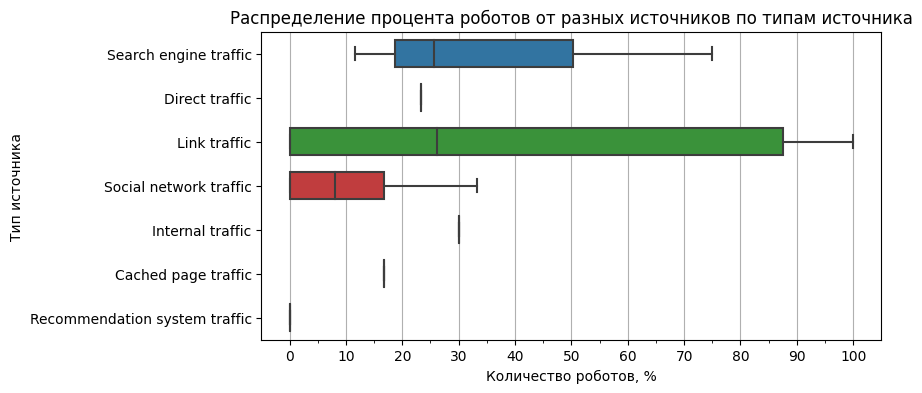

In [18]:
fig_source_engine = plt.figure(figsize=(8, 4))
boxplot = sns.boxplot(
    data=data_source_engine_df,
    y='traffic-source',
    x='robot%',
    orient='h',
    width=0.6
)
boxplot.set_title('Распределение процента роботов от разных источников по типам источника');
boxplot.set_xlabel('Количество роботов, %');
boxplot.set_ylabel('Тип источника');
boxplot.grid(axis='x',which='major');
boxplot.set_axisbelow(True);
boxplot.set_xticks([0,10,20,30,40,50,60,70,80,90,100], minor=False);
boxplot.set_xticks([5,15,25,35,45,55,65,75,85,95], minor=True);

**ВЫВОД**:  
В типах источника Link traffic, Search engine traffic и Social network traffic наблюдается большой разброс процента роботов от конкретных источников внутри типа (типы перечислены в порядке убывания разброса). 
Поэтому делать выводы о проценте роботов только по типам источников, без детализации по конкретным источникам, может быть некорректно.  

Построим диаграммы процента роботов от конкретных источников-фавиконов для источников типа Link traffic, Search engine traffic и Social network traffic.

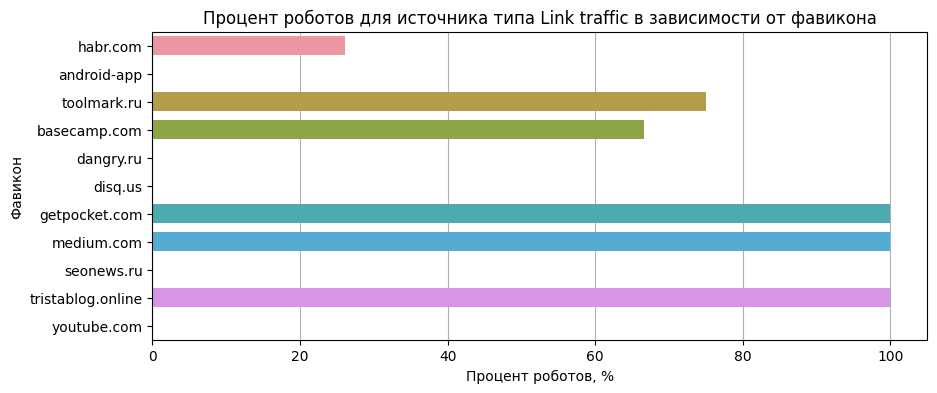

In [19]:
fig_social = plt.figure(figsize=(10, 4))
barplot = sns.barplot(
    data=data_source_engine_df[data_source_engine_df['traffic-source']=='Link traffic'],
    y='favicon',
    x='robot%',
    orient='h',
    width=0.7
)
barplot.set_title('Процент роботов для источника типа Link traffic в зависимости от фавикона');
barplot.set_xlabel('Процент роботов, %');
barplot.set_ylabel('Фавикон');
barplot.grid(axis='x');
barplot.set_axisbelow(True);

**ВЫВОД**:  
Для типа Link traffic лидерами по проценту визитов роботов являются:
1. getpocket.com , medium.com и tristablog.online (100% роботов); однако от этих источников имеется всего по одному визиту
2. toolmark.ru (75% роботов); всего 4 визита
3. basecamp.com (67% роботов); всего 3 визита

Для источников со значимым числом визитов процент роботов не столь велик (0-26 %)

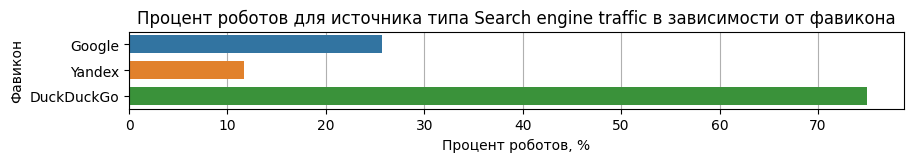

In [20]:
fig_social = plt.figure(figsize=(10, 1))
barplot = sns.barplot(
    data=data_source_engine_df[data_source_engine_df['traffic-source']=='Search engine traffic'],
    y='favicon',
    x='robot%',
    orient='h',
    width=0.7
)
barplot.set_title('Процент роботов для источника типа Search engine traffic в зависимости от фавикона');
barplot.set_xlabel('Процент роботов, %');
barplot.set_ylabel('Фавикон');
barplot.grid(axis='x');
barplot.set_axisbelow(True);

**ВЫВОД**:  
Для типа Search engine traffic по проценту визитов роботов 3 источника заняли следующие места:
1. DuckDuckGo (75% роботов); однако от этого источника имеется всего 4 визита
2. Google (26% роботов)
3. Yandex (12% роботов) 

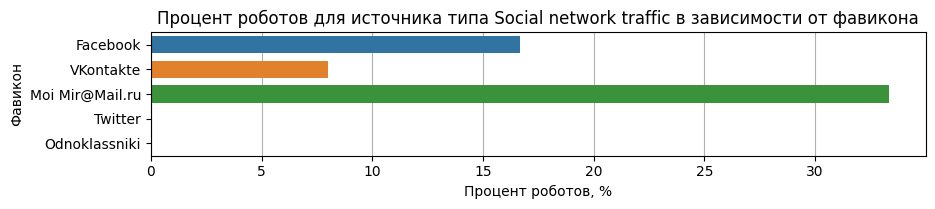

In [21]:
fig_social = plt.figure(figsize=(10, 1.6))
barplot = sns.barplot(
    data=data_source_engine_df[data_source_engine_df['traffic-source']=='Social network traffic'],
    y='favicon',
    x='robot%',
    orient='h',
    width=0.7
)
barplot.set_title('Процент роботов для источника типа Social network traffic в зависимости от фавикона');
barplot.set_xlabel('Процент роботов, %');
barplot.set_ylabel('Фавикон');
barplot.grid(axis='x');
barplot.set_axisbelow(True);

**ВЫВОД**:  
Для типа Social network traffic лидерами по проценту визитов роботов являются::
1. Moi Mir@Mail.ru (33% роботов); однако от этого источника имеется всего 4 визита
2. Facebook (17% роботов)

Odnoklassniki и Twitter не дают роботов вообще.

Построим диаграмму процента роботов от конкретных источников-фавиконов для всех типов источников:

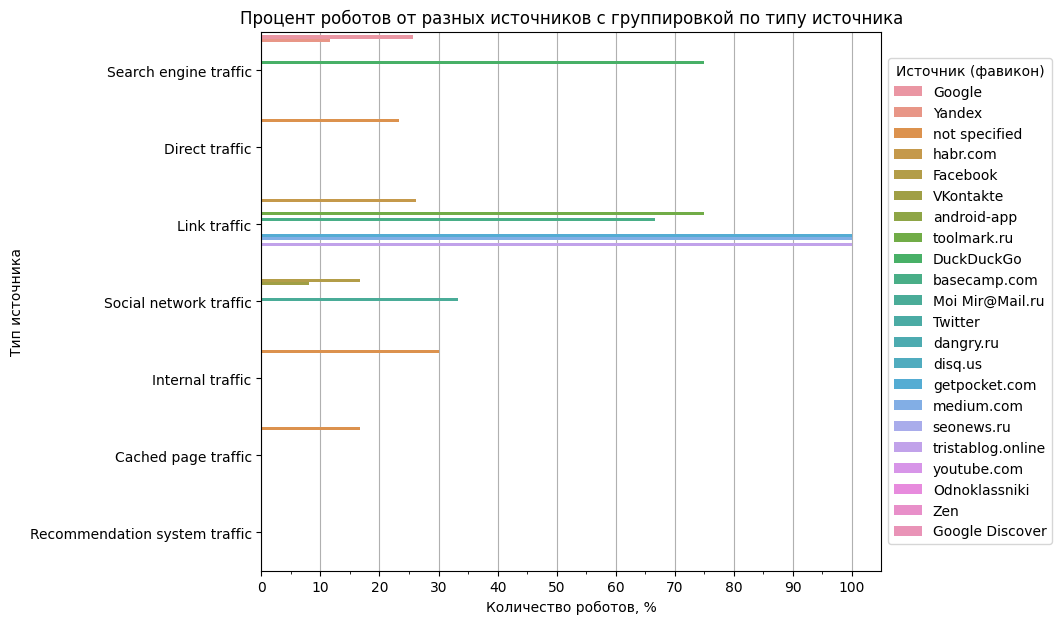

In [22]:
fig_social = plt.figure(figsize=(8, 7))
barplot = sns.barplot(
    data=data_source_engine_df,
    y='traffic-source',
    x='robot%',
    hue='favicon',
    orient='h',
    width=0.9
)
barplot.set_title('Процент роботов от разных источников с группировкой по типу источника');
barplot.set_xlabel('Количество роботов, %');
barplot.set_ylabel('Тип источника');
barplot.grid(axis='x', which='major');
barplot.set_axisbelow(True);
barplot.legend(title='Источник (фавикон)', loc='center left', bbox_to_anchor=(1,0.5));   #, framealpha=1, facecolor='w');
barplot.set_xticks([0,10,20,30,40,50,60,70,80,90,100], minor=False);
barplot.set_xticks([5,15,25,35,45,55,65,75,85,95], minor=True);

Посмотрим на количество и процент роботов от различных источников (без группировки по типам):

In [23]:
print('Визиты роботов (сортировка по количеству роботов):')
display(data_source_engine_df.sort_values(['visits_of_robots'],ascending=False))
print('Визиты роботов (сортировка по проценту роботов):')
display(data_source_engine_df.sort_values(['robot%','traffic-source','favicon'],ascending=[False,True,True]))

Визиты роботов (сортировка по количеству роботов):


,traffic-source,favicon,visits,robot%,visits_of_robots,visits_of_people
0,Search engine traffic,Google,2474,25.71,636,1838
2,Direct traffic,not specified,757,23.38,177,580
1,Search engine traffic,Yandex,856,11.68,100,756
3,Link traffic,habr.com,88,26.14,23,65
4,Social network traffic,Facebook,48,16.67,8,40
7,Internal traffic,not specified,10,30.00,3,7
9,Link traffic,toolmark.ru,4,75.00,3,1
10,Search engine traffic,DuckDuckGo,4,75.00,3,1
5,Social network traffic,VKontakte,25,8.00,2,23
11,Link traffic,basecamp.com,3,66.67,2,1


Визиты роботов (сортировка по проценту роботов):


,traffic-source,favicon,visits,robot%,visits_of_robots,visits_of_people
16,Link traffic,getpocket.com,1,100.00,1,0
17,Link traffic,medium.com,1,100.00,1,0
19,Link traffic,tristablog.online,1,100.00,1,0
9,Link traffic,toolmark.ru,4,75.00,3,1
10,Search engine traffic,DuckDuckGo,4,75.00,3,1
11,Link traffic,basecamp.com,3,66.67,2,1
12,Social network traffic,Moi Mir@Mail.ru,3,33.33,1,2
7,Internal traffic,not specified,10,30.00,3,7
3,Link traffic,habr.com,88,26.14,23,65
0,Search engine traffic,Google,2474,25.71,636,1838


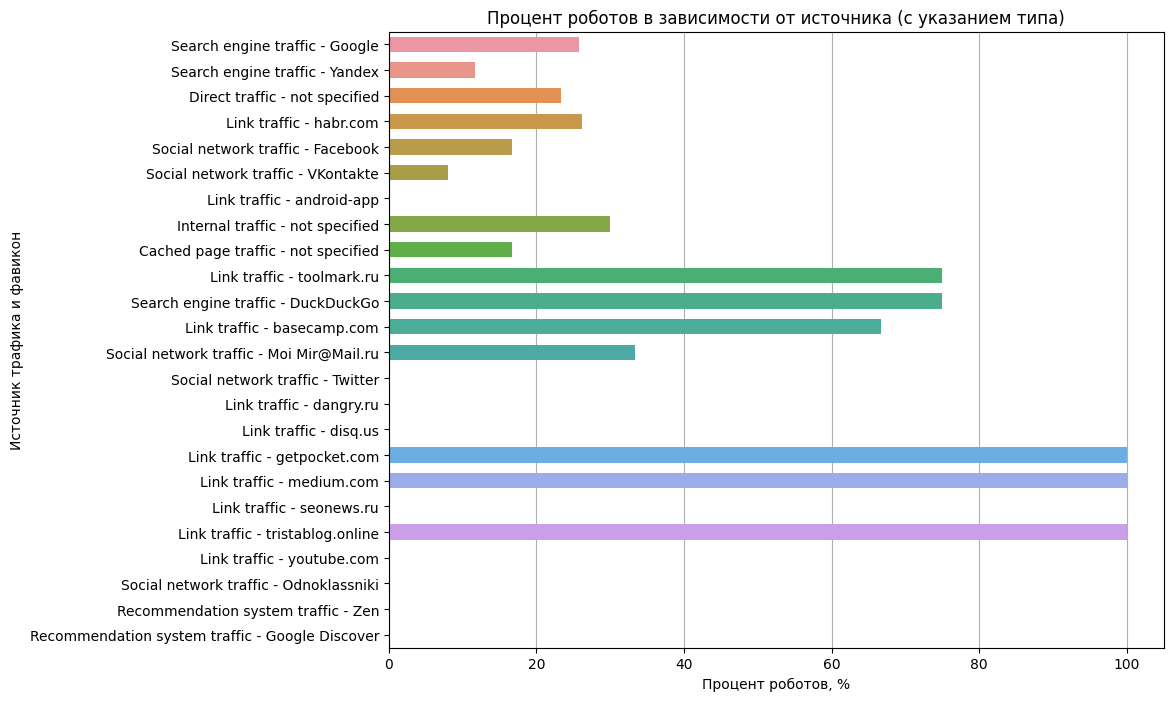

In [24]:
data_source_engine_df['source+engine']=data_source_engine_df['traffic-source'] + ' - ' + data_source_engine_df['favicon']
    # оъединение столбцов traffic-source и favicon в единый столбец
fig_social = plt.figure(figsize=(10, 8))
barplot = sns.barplot(
    data=data_source_engine_df,
    y='source+engine',
    x='robot%',
    orient='h',
    width=0.6
)
barplot.set_title('Процент роботов в зависимости от источника (с указанием типа)');
barplot.set_xlabel('Процент роботов, %');
barplot.set_ylabel('Источник трафика и фавикон');
barplot.grid(axis='x');
barplot.set_axisbelow(True);

**ВЫВОДЫ**  по конкретным источникам-фавиконам (без группировки по типам): 
 
**По количеству визитов роботов** лидируют:  
1. Google (тип - Search engine traffic) - 636 роботов (26% роботов от числа визитов)
2. неопределенные источники типа Direct traffic - 177 роботов (23% роботов от числа визитов)
3. Yandex (тип - Search engine traffic) – 100 роботов (12% роботов от числа визитов) 

**В процентах количества роботов от общего числа визитов** от источника лидируют:
1. getpocket.com , medium.com и tristablog.online (все типа Link traffic) - 100% роботов; однако от этих источников имеется всего по одному визиту
2. toolmark.ru (Link traffic) и DuckDuckGo (Search engine traffic) - 75% роботов; однако от этих источников имеется всего по 4 визита
3. basecamp.com ((Link traffic) - 67% роботов; однако от этого источника имеется всего 3 визита

**Источники-лидеры по общему количеству визитов показали следующий процент роботов**:
1. Google (тип - Search engine traffic) - 26% роботов от числа визитов
2. неопределенные источники типа Direct traffic - 23% роботов от числа визитов
3. Yandex (тип - Search engine traffic) - 12% роботов от числа визитов
   
- Эти же источники лидируют по количеству визитов роботов.

### 5. Определим, в какое время суток чаще всего заходят роботы.
1. Рассмотрим зависимость активности роботов от времени суток без деления по типам источника трафика. При этом посмотрим отдельно на рабочие дни (пн-пт) и выходные дни (сб-вс). Сравним динамику активности у людей и роботов.  
2. Рассмотрим зависимость активности роботов от времени суток и типа источника трафика.   

#### 5.1. Зависимость активности роботов от времени суток по рабочим и выходным дням. 
Сделаем запрос данных по визитам с группировкой по дате, дню недели, часу начала визита и по признаку "человек/робот":

In [25]:
params_time = {'metrics':  'ym:s:visits,ym:s:avgVisitDurationSeconds', 
            'dimensions':   'ym:s:date,ym:s:dayOfWeekName,ym:s:hour,ym:s:isRobotName',   
            'date1': '2020-09-01',  
            'date2': '2020-09-30',     
            'ids': 30177909,
            'accuracy':'full',
            'limit' : 10000}

response_time = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params_time, headers=headers)
print('\nResponse status code       :  ', response_time.status_code)

response_time_data = response_time.json()
print('Number of rows in response :  ', response_time_data['total_rows'])
print('\nResponse keys :\n', response_time_data.keys())
print('\nResponce data value :')
pprint(response_time_data['data'])


Response status code       :   200
Number of rows in response :   1099

Response keys :
 dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])

Responce data value :
[{'dimensions': [{'name': '2020-09-22'},
                 {'name': 'Tuesday'},
                 {'id': '15', 'name': '15:00'},
                 {'name': 'People'}],
  'metrics': [18.0, 85.11111111]},
 {'dimensions': [{'name': '2020-09-20'},
                 {'name': 'Sunday'},
                 {'id': '21', 'name': '21:00'},
                 {'name': 'People'}],
  'metrics': [16.0, 220.1875]},
 {'dimensions': [{'name': '2020-09-28'},
                 {'name': 'Monday'},
                 {'id': '13', 'name': '13:00'},
                 {'name': 'People'}],
  'metrics': [16.0, 172.6875]},
 {'dimensions': [{'name': '2020-09-08'},
                 {'name': 'Tuesday'},
                 {'id': '17', 

In [26]:
data_time_df=pd.DataFrame(data = response_time_data['data']) 
pd.set_option('display.max_rows', 4) 
display(data_time_df)

,dimensions,metrics
0,"[{'name': '2020-09-22'}, {'name': 'Tuesday'}, ...","[18.0, 85.11111111]"
1,"[{'name': '2020-09-20'}, {'name': 'Sunday'}, {...","[16.0, 220.1875]"
...,...,...
1097,"[{'name': '2020-09-30'}, {'name': 'Wednesday'}...","[1.0, 18.0]"
1098,"[{'name': '2020-09-30'}, {'name': 'Wednesday'}...","[1.0, 0.0]"


In [27]:
data_time_df['date']=data_time_df['dimensions'].apply(lambda x: x[0]['name'])
data_time_df['DoW']=data_time_df['dimensions'].apply(lambda x: x[1]['name'])
data_time_df['hour']=data_time_df['dimensions'].apply(lambda x: x[2]['name']) \
    .apply(lambda x: x.replace(':00','')).astype('int')    #уберем минуты
data_time_df['robot?']=data_time_df['dimensions'].apply(lambda x: x[3]['name'])
data_time_df['visits']=data_time_df['metrics'].apply(lambda x: round(x[0]))
data_time_df['avgVisitDurationSec']=data_time_df['metrics'].apply(lambda x: round(x[1],1))
data_time_df.drop(['dimensions','metrics'],axis=1,inplace=True)
display(data_time_df)

,date,DoW,hour,robot?,visits,avgVisitDurationSec
0,2020-09-22,Tuesday,15,People,18,85.1
1,2020-09-20,Sunday,21,People,16,220.2
...,...,...,...,...,...,...
1097,2020-09-30,Wednesday,21,Robots,1,18.0
1098,2020-09-30,Wednesday,23,Robots,1,0.0


Добавим столбец с признаком рабочего или выходного дня:

In [28]:
data_time_df['day_type']=data_time_df['DoW'].apply(lambda x: 'weekend' if (x=='Saturday' or x=='Sunday') else 'working')
display(data_time_df)

,date,DoW,hour,robot?,visits,avgVisitDurationSec,day_type
0,2020-09-22,Tuesday,15,People,18,85.1,working
1,2020-09-20,Sunday,21,People,16,220.2,weekend
...,...,...,...,...,...,...,...
1097,2020-09-30,Wednesday,21,Robots,1,18.0,working
1098,2020-09-30,Wednesday,23,Robots,1,0.0,working


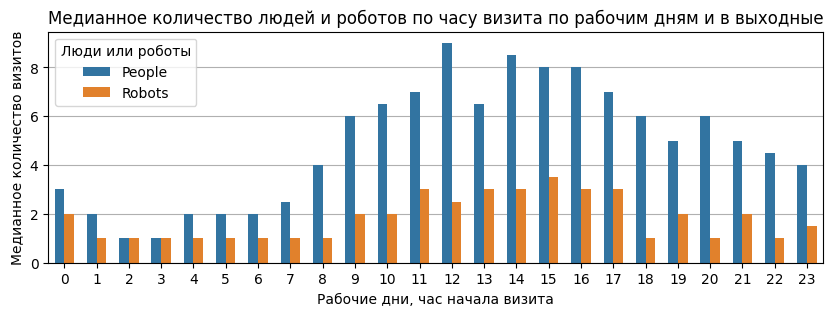

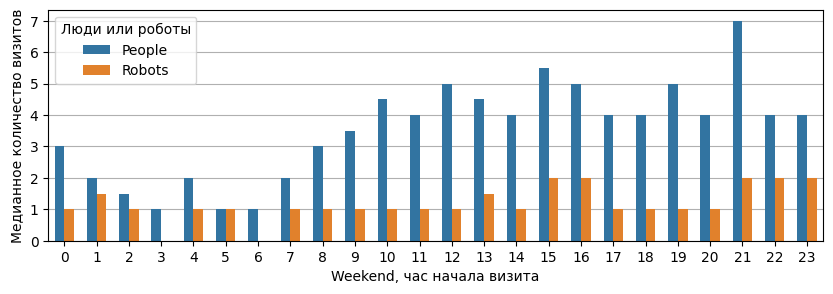

In [29]:
fig_working= plt.figure(figsize=(10, 3))
barplot = sns.barplot(
    data=data_time_df[data_time_df['day_type']=='working'],
    y='visits',
    x='hour',
    hue='robot?',
    orient='v',
    width=0.6,
    errorbar=None,
    estimator='median')
barplot.set_title('Медианное количество людей и роботов по часу визита по рабочим дням и в выходные');
barplot.set_xlabel('Рабочие дни, час начала визита');
barplot.set_ylabel('Медианное количество визитов');
barplot.grid(axis='y',which='major');
barplot.set_axisbelow(True);
barplot.legend (title='Люди или роботы', loc='upper left');

fig_weekend = plt.figure(figsize=(10, 3))
barplot = sns.barplot(
    data=data_time_df[data_time_df['day_type']=='weekend'],
    y='visits',
    x='hour',
    hue='robot?',
    orient='v',
    width=0.6,
    errorbar=None,
    estimator='median')
barplot.set_xlabel('Weekend, час начала визита');
barplot.set_ylabel('Медианное количество визитов');
barplot.grid(axis='y',which='major');
barplot.set_axisbelow(True);
barplot.legend (title='Люди или роботы', loc='upper left');

**ВЫВОДЫ**:   
1. Сравнение характера динамики визитов людей и роботов по времени суток:
   - По рабочим дням динамика визитов роботов в целом повторяет динамику визитов людей - после ночного спада наблюдается постепенный рост числа визитов, достигающий максимума днем и снижающийся к началу ночи. При этом пик динамики визита роботов немного смещен на более позднее время и гораздо менее выражен чам у людей.
   - По выходным динамика визитов роботов силбнее отличается от динамики визитов людей - у роботов пики активности сильно сглажены.
2. Пики активности роботов приходятся:
   - по рабочим дням - на период с 11 до 18 часов, максимум наблюдется в 15 часов;
   - по выходным - имеется два пика активности - с 15 до 17 часов и с 21 до 24 часов; явных максимумов в пределах пиков не наблюдается.

#### 5.2. Зависимость активности роботов от времени суток и типа источника трафика. 
Сделаем запрос данных по визитам с группировкой по дате, дню недели, часу начала визита, признаку "человек/робот" и типу источника трафика:

In [30]:
params_time_detailed = {  'metrics':  'ym:s:visits', 
            'dimensions':   'ym:s:lastSignTrafficSource,ym:s:lastSourceEngine, \
                             ym:s:date,ym:s:dayOfWeekName,ym:s:hour,ym:s:isRobotName',  
            'date1': '2020-09-01',  
            'date2': '2020-09-30',     
            'ids': 30177909,
            'accuracy':'full',
            'limit' : 10000}

response_time_detailed = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params_time_detailed, headers=headers)
print('\nResponse status code       :  ', response_time_detailed.status_code)

response_time_detailed_data = response_time_detailed.json()
print('Number of rows in response :  ', response_time_detailed_data['total_rows'])
print('\nResponse keys :\n', response_time_detailed_data.keys())
print('\nResponce data value :')
pprint(response_time_detailed_data['data'])


Response status code       :   200
Number of rows in response :   2403

Response keys :
 dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])

Responce data value :
[{'dimensions': [{'icon_id': '0',
                  'icon_type': 'traffic-source',
                  'id': 'direct',
                  'name': 'Direct traffic'},
                 {'favicon': None, 'id': None, 'name': None, 'url': None},
                 {'name': '2020-09-20'},
                 {'name': 'Sunday'},
                 {'id': '21', 'name': '21:00'},
                 {'name': 'People'}],
  'metrics': [11.0]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'favicon': 'google.com',
                  'id': 'organic.google',
                  'name

In [31]:
data_time_detailed_df=pd.DataFrame(data = response_time_detailed_data['data']) 
pd.set_option('display.max_rows', 4) 
display(data_time_detailed_df)

,dimensions,metrics
0,"[{'icon_id': '0', 'icon_type': 'traffic-source...",[11.0]
1,"[{'icon_id': '2', 'icon_type': 'traffic-source...",[11.0]
...,...,...
2401,"[{'icon_id': '9', 'icon_type': 'traffic-source...",[1.0]
2402,"[{'icon_id': '9', 'icon_type': 'traffic-source...",[1.0]


In [32]:
data_time_detailed_df['traffic-source']=data_time_detailed_df['dimensions'].apply(lambda x: x[0]['name'])
data_time_detailed_df['favicon']=data_time_detailed_df['dimensions'].apply(lambda x: x[1]['name'])
data_time_detailed_df['date']=data_time_detailed_df['dimensions'].apply(lambda x: x[2]['name'])
data_time_detailed_df['DoW']=data_time_detailed_df['dimensions'].apply(lambda x: x[3]['name'])
data_time_detailed_df['hour']=data_time_detailed_df['dimensions'].apply(lambda x: x[4]['name']) \
    .apply(lambda x: x.replace(':00','')).astype('int')    #уберем минуты
data_time_detailed_df['robot?']=data_time_detailed_df['dimensions'].apply(lambda x: x[5]['name'])
data_time_detailed_df['visits']=data_time_detailed_df['metrics'].apply(lambda x: round(x[0]))
data_time_detailed_df.drop(['dimensions','metrics'],axis=1,inplace=True)
display(data_time_detailed_df)

,traffic-source,favicon,date,DoW,hour,robot?,visits
0,Direct traffic,None,2020-09-20,Sunday,21,People,11
1,Search engine traffic,Google,2020-09-28,Monday,20,People,11
...,...,...,...,...,...,...,...
2401,Recommendation system traffic,Zen,2020-09-26,Saturday,8,People,1
2402,Recommendation system traffic,Google Discover,2020-09-21,Monday,14,People,1


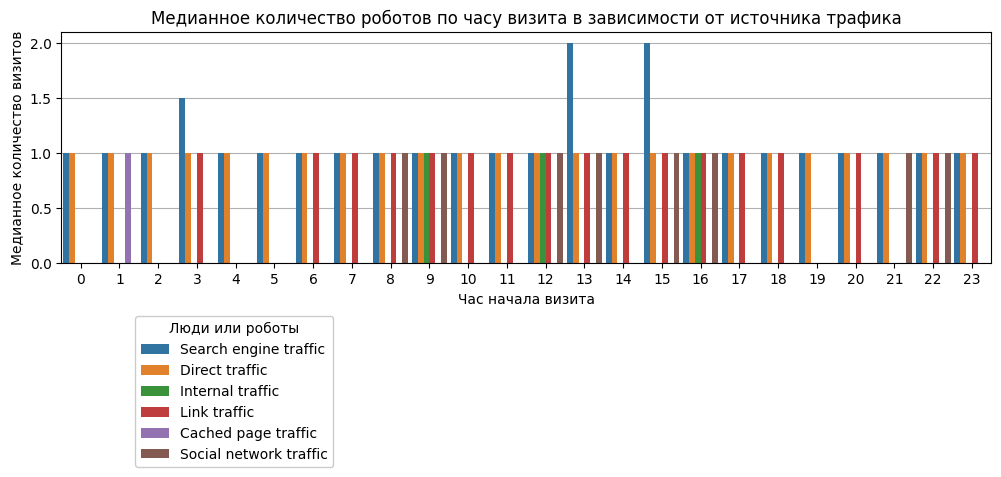

In [33]:
fig_time_vs_source = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data=data_time_detailed_df[data_time_detailed_df['robot?']=='Robots'],
    y='visits',
    x='hour',
    hue='traffic-source',
    orient='v',
    width=0.9,
    errorbar=None,
    estimator='median')
barplot.set_title('Медианное количество роботов по часу визита в зависимости от источника трафика');
barplot.set_xlabel('Час начала визита');
barplot.set_ylabel('Медианное количество визитов');
barplot.grid(axis='y',which='major');
barplot.set_axisbelow(True);
barplot.legend (title='Люди или роботы', bbox_to_anchor=(0.3, -0.2), framealpha=1, facecolor='w');

**ВЫВОДЫ**:   
- Зависимость активности роботов от времени суток наблюдается только для источника типа Search engine traffic - в целом равномерная активность имеет локальные пики между 14-15, 13-14 и 15-16 часами.
- По другим источникам активность робота равномерна в течении суток.

## 6. Подытожим выводы.
### Оценка количество ботов, которые заходят на сайт, и их доли от всего трафика.
- **Всего** за сентябрь было зафиксировано 4315 визитов, сделанных 3166 уникальными посетителями;
   - из этих 4315 визитов 22% предположительно сделаны роботами;
   - из этих 3166 уникальных посетителей 24% предположительно являются роботами.
- Дополнительные выводы:
   - посетитель-робот в среднем совершает чуть меньше визитов чем посетитель-человек;
   - продолжительность визита у робота в среднем немного меньше чем у чедовека;
   - в среднем количество просмотров страниц у людей и роботов практически одинаковое;
   - в среднем глубина просмотра страниц у людей и роботов практически одинаковая.
### Из каких источников чаще всего заходят роботы.
- **В абсолютном значении** больше всего роботов приходило из следующих типов источника:
   1. Search engine traffic (739 визита роботов);
   2. Direct traffic (177 визита роботов). 
   - Эти типы источников занимают такие же места и по общему количеству визитов и по количеству визитов людей.
- **В процентах** от количества визитов по типу источника наибольшая доля роботов наблюдается для следующих типов источника:
   1. Internal traffic (30%);
   2. Link traffic	(25%);
   3. Direct traffic	(23%);
   4. Search engine traffic	(22%).
- В типах источника Link traffic, Search engine traffic и Social network traffic наблюдается большой разброс процента роботов от конкретных источников внутри типа (типы перечислены в порядке убывания разброса). 
   - Для типа **Link traffic** лидерами по проценту визитов роботов являются:
      1. getpocket.com , medium.com и tristablog.online (100% роботов); однако от этих источников имеется всего по одному визиту
      2. toolmark.ru (75% роботов); всего 4 визита
      3. basecamp.com (67% роботов); всего 3 визита
     - Для источников со значимым числом визитов процент роботов не столь велик (0-26 %)
   - Для типа **Search engine traffic** по проценту визитов роботов 3 источника заняли следующие места:
      1. DuckDuckGo (75% роботов); однако от этого источника имеется всего 4 визита
      2. Google (26% роботов)
      3. Yandex (12% роботов) 
   - Для типа **Social network traffic** лидерами по проценту визитов роботов являются::
      1. Moi Mir@Mail.ru (33% роботов); однако от этого источника имеется всего 4 визита
      2. Facebook (17% роботов)
      - Odnoklassniki и Twitter не дают роботов вообще.
- **По конкретным источникам-фавиконам** (без группировки по типам):   
   - **По количеству визитов роботов** лидируют:  
      1. Google (тип - Search engine traffic) - 636 роботов (26% роботов от числа визитов)
      2. неопределенные источники типа Direct traffic - 177 роботов (23% роботов от числа визитов)
      3. Yandex (тип - Search engine traffic) – 100 роботов (12% роботов от числа визитов) 
   - **В процентах количества роботов от общего числа визитов** от источника лидируют:
      1. getpocket.com , medium.com и tristablog.online (все типа Link traffic) - 100% роботов; однако от этих источников имеется всего по одному визиту
      2. toolmark.ru (Link traffic) и DuckDuckGo (Search engine traffic) - 75% роботов; однако от этих источников имеется всего по 4 визита
      3. basecamp.com ((Link traffic) - 67% роботов; однако от этого источника имеется всего 3 визита
   - **Источники-лидеры по общему количеству визитов показали следующий процент роботов**:
      1. Google (тип - Search engine traffic) - 26% роботов от числа визитов
      2. неопределенные источники типа Direct traffic - 23% роботов от числа визитов
      3. Yandex (тип - Search engine traffic) - 12% роботов от числа визитов
      - Эти же источники лидируют по количеству визитов роботов.
### В какое время суток чаще всего заходят роботы.   
- Сравнение **характера динамики визитов людей и роботов по времени суток**:
   - По рабочим дням динамика визитов роботов в целом повторяет динамику визитов людей - после ночного спада наблюдается постепенный рост числа визитов, достигающий максимума днем и снижающийся к началу ночи. При этом пик динамики визита роботов немного смещен на более позднее время и гораздо менее выражен чам у людей.
   - По выходным динамика визитов роботов силбнее отличается от динамики визитов людей - у роботов пики активности сильно сглажены.
- **Пики активности роботов** приходятся:
   - по рабочим дням - на период с 11 до 18 часов, максимум наблюдется в 15 часов;
   - по выходным - имеется два пика активности - с 15 до 17 часов и с 21 до 24 часов; явных максимумов в пределах пиков не наблюдается.
- **Зависимость активности роботов от времени суток наблюдается только для источника типа Search engine traffic** - в целом равномерная активность имеет локальные пики между 14-15, 13-14 и 15-16 часами. По другим источникам активность робота равномерна в течении суток.
